In [1]:
import os
import numpy as np 
import pandas as pd 
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GroupShuffleSplit


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Any, Dict, Union

from yellowbrick import model_selection as ms
from yellowbrick.model_selection import validation_curve

from sklearn import metrics

from xgboost import XGBClassifier


from boruta import BorutaPy
from BorutaShap import BorutaShap, load_data
from sklearn.model_selection import train_test_split

In [2]:
os.chdir('/home/melissa/RESULTS/XGBoost/Human_SYNGAP1/Datasets/')
all_patients = pd.read_csv('df_all_patients_IDS.csv')


In [5]:
genotype_human = {'P1': 'WT', 'P2': 'GAP', 'P3': 'GAP', 'P4': 'WT', 
                  'P5': 'GAP', 'P6': 'GAP', 'P7': 'GAP', 'P8' : 'WT',
                  'P9': 'GAP', 'P10': 'GAP', 'P11': 'WT', 'P12': 'WT',
                  'P13': 'GAP', 'P14': 'WT', 'P15': 'GAP', 'P16': 'GAP',
                  'P17': 'WT', 'P18': 'WT', 'P19': 'WT', 'P20': 'GAP',
                  'P21': 'WT', 'P22': 'GAP', 'P23': 'GAP', 'P24': 'WT',
                  'P25': 'WT', 'P26': 'GAP', 'P27': 'WT', 'P28': 'WT',
                  'P29': 'WT', 'P30': 'GAP'} 

In [8]:
all_ids = [ 'P10','P15','P16',
             'P20','P21','P21', 'P21',
             'P27', 'P24', 'P26',
              'P5', 'P17', 'P28', 'P28', 'P6', 'P7', 'P1']

numbers = all_patients['Unnamed: 0'].tolist()
break_indices = [i for i in range(1, len(numbers)) if numbers[i] - numbers[i - 1] != 1]

indices = [0, 96,373,
 505,
 734,
 859,
 1036,
 1258,
 1785,
 1978,
 2178,
 2244,
 2451,
 2694,
 3139,
 3284,3572]

differences = [indices[i] - indices[i - 1] for i in range(1, len(indices))]

all_patients_ls = []
for patient_id, num in zip(all_ids, differences):
    idx_list = [patient_id]*num
    all_patients_ls.append(idx_list)

patient_id_column = [patient for patient_ls in all_patients_ls for patient in patient_ls]

In [7]:
#all_patients['Patient_ID'] = patient_id_column

column_to_move = 'Patient_ID'
new_column_order = [column_to_move] + [col for col in all_patients.columns if col != column_to_move]

# Reassign the DataFrame's columns using this new order
all_patients = all_patients[new_column_order]
all_patients

,Patient_ID,Unnamed: 0,Genotype,Hurst_E1,Hurst_E2,Hurst_O1,Hurst_C3,Hurst_F3,Hurst_M2,Dispen_E1,...,E2_F3_phase_lock,E2_C3_phase_lock,E2_O1_phase_lock,E2_M2_phase_lock,F3_C3_phase_lock,F3_O1_phase_lock,F3_M2_phase_lock,C3_O1_phase_lock,C3_M2_phase_lock,O1_M2_phase_lock
0,P6,0,1,3.262335,3.939851,4.202927,4.024169,3.914120,4.701832,2.081332,...,0.131191,0.160906,0.028797,0.044730,0.059119,0.100674,0.162270,0.038602,0.662702,0.201518
1,P6,1,1,-0.393308,0.758725,0.565811,0.662099,0.650113,0.615971,2.366289,...,0.141938,0.139012,0.033578,0.044440,0.061324,0.076790,0.167004,0.054018,0.676922,0.187127
2,P6,2,1,-1.492526,0.701736,0.549797,0.588715,0.609258,0.531938,2.463711,...,0.114935,0.176147,0.028737,0.054153,0.069330,0.067405,0.126345,0.045793,0.684068,0.182023
3,P6,3,1,-0.767541,0.738484,0.558011,0.485269,0.475022,0.479210,2.438271,...,0.048777,0.145820,0.031422,0.051468,0.067250,0.067823,0.110469,0.053287,0.687971,0.162106
4,P6,4,1,-3.608446,0.664564,0.444736,0.485577,0.455710,0.450246,2.441381,...,0.105989,0.199312,0.023620,0.062880,0.029902,0.068079,0.123423,0.048230,0.684389,0.144952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,P28,3567,0,1.011602,0.445987,0.602566,0.589067,0.443827,0.530432,2.297590,...,0.033722,0.171985,0.075585,0.230777,0.429384,0.353852,0.069761,0.167856,0.314116,0.460712
3568,P28,3568,0,0.953962,0.481252,0.650899,0.642726,0.531036,0.565655,2.209516,...,0.007580,0.184549,0.069532,0.216088,0.432927,0.349865,0.079424,0.149430,0.292945,0.433388
3569,P28,3569,0,0.964713,0.499629,0.598202,0.605621,0.500773,0.505756,2.236090,...,0.024629,0.192478,0.075815,0.204453,0.437592,0.339216,0.072066,0.156285,0.283497,0.451280
3570,P28,3570,0,-3.903140,0.590368,0.656417,0.634468,0.583174,0.515904,1.583559,...,0.035864,0.191338,0.082433,0.181427,0.412056,0.330528,0.070924,0.185784,0.309707,0.435668


In [9]:
for idx in all_ids:
    
    genotype =  genotype_human[idx]
    print(genotype)
    
    length = len(all_patients.loc[all_patients['Patient_ID'] == str(idx)])
    
    
    print(f"{idx}: {length}, {genotype},")

GAP
P10: 222, GAP,
GAP
P15: 0, GAP,
GAP
P16: 177, GAP,
GAP
P20: 125, GAP,
WT
P21: 638, WT,
WT
P21: 638, WT,
WT
P21: 638, WT,
WT
P27: 200, WT,
WT
P24: 207, WT,
GAP
P26: 193, GAP,
GAP
P5: 243, GAP,
WT
P17: 66, WT,
WT
P28: 433, WT,
WT
P28: 433, WT,
GAP
P6: 96, GAP,
GAP
P7: 445, GAP,
WT
P1: 527, WT,


In [6]:
#all_patients['Patient_ID'] = all_patients['Patient_ID'].str.split().str[0]

In [7]:
all_patients

,Patient_ID,Unnamed: 0,Genotype,Hurst_E1,Hurst_E2,Hurst_O1,Hurst_C3,Hurst_F3,Hurst_M2,Dispen_E1,...,E2_F3_phase_lock,E2_C3_phase_lock,E2_O1_phase_lock,E2_M2_phase_lock,F3_C3_phase_lock,F3_O1_phase_lock,F3_M2_phase_lock,C3_O1_phase_lock,C3_M2_phase_lock,O1_M2_phase_lock
0,P6,0,1,3.262335,3.939851,4.202927,4.024169,3.914120,4.701832,2.081332,...,0.131191,0.160906,0.028797,0.044730,0.059119,0.100674,0.162270,0.038602,0.662702,0.201518
1,P6,1,1,-0.393308,0.758725,0.565811,0.662099,0.650113,0.615971,2.366289,...,0.141938,0.139012,0.033578,0.044440,0.061324,0.076790,0.167004,0.054018,0.676922,0.187127
2,P6,2,1,-1.492526,0.701736,0.549797,0.588715,0.609258,0.531938,2.463711,...,0.114935,0.176147,0.028737,0.054153,0.069330,0.067405,0.126345,0.045793,0.684068,0.182023
3,P6,3,1,-0.767541,0.738484,0.558011,0.485269,0.475022,0.479210,2.438271,...,0.048777,0.145820,0.031422,0.051468,0.067250,0.067823,0.110469,0.053287,0.687971,0.162106
4,P6,4,1,-3.608446,0.664564,0.444736,0.485577,0.455710,0.450246,2.441381,...,0.105989,0.199312,0.023620,0.062880,0.029902,0.068079,0.123423,0.048230,0.684389,0.144952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,P28,3567,0,1.011602,0.445987,0.602566,0.589067,0.443827,0.530432,2.297590,...,0.033722,0.171985,0.075585,0.230777,0.429384,0.353852,0.069761,0.167856,0.314116,0.460712
3568,P28,3568,0,0.953962,0.481252,0.650899,0.642726,0.531036,0.565655,2.209516,...,0.007580,0.184549,0.069532,0.216088,0.432927,0.349865,0.079424,0.149430,0.292945,0.433388
3569,P28,3569,0,0.964713,0.499629,0.598202,0.605621,0.500773,0.505756,2.236090,...,0.024629,0.192478,0.075815,0.204453,0.437592,0.339216,0.072066,0.156285,0.283497,0.451280
3570,P28,3570,0,-3.903140,0.590368,0.656417,0.634468,0.583174,0.515904,1.583559,...,0.035864,0.191338,0.082433,0.181427,0.412056,0.330528,0.070924,0.185784,0.309707,0.435668


In [8]:
df_clean = all_patients.drop(['Unnamed: 0'], axis = 1)
df_clean

,Patient_ID,Genotype,Hurst_E1,Hurst_E2,Hurst_O1,Hurst_C3,Hurst_F3,Hurst_M2,Dispen_E1,Dispen_E2,...,E2_F3_phase_lock,E2_C3_phase_lock,E2_O1_phase_lock,E2_M2_phase_lock,F3_C3_phase_lock,F3_O1_phase_lock,F3_M2_phase_lock,C3_O1_phase_lock,C3_M2_phase_lock,O1_M2_phase_lock
0,P6,1,3.262335,3.939851,4.202927,4.024169,3.914120,4.701832,2.081332,1.936287,...,0.131191,0.160906,0.028797,0.044730,0.059119,0.100674,0.162270,0.038602,0.662702,0.201518
1,P6,1,-0.393308,0.758725,0.565811,0.662099,0.650113,0.615971,2.366289,2.094071,...,0.141938,0.139012,0.033578,0.044440,0.061324,0.076790,0.167004,0.054018,0.676922,0.187127
2,P6,1,-1.492526,0.701736,0.549797,0.588715,0.609258,0.531938,2.463711,1.938687,...,0.114935,0.176147,0.028737,0.054153,0.069330,0.067405,0.126345,0.045793,0.684068,0.182023
3,P6,1,-0.767541,0.738484,0.558011,0.485269,0.475022,0.479210,2.438271,1.927775,...,0.048777,0.145820,0.031422,0.051468,0.067250,0.067823,0.110469,0.053287,0.687971,0.162106
4,P6,1,-3.608446,0.664564,0.444736,0.485577,0.455710,0.450246,2.441381,2.235039,...,0.105989,0.199312,0.023620,0.062880,0.029902,0.068079,0.123423,0.048230,0.684389,0.144952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,P28,0,1.011602,0.445987,0.602566,0.589067,0.443827,0.530432,2.297590,2.011263,...,0.033722,0.171985,0.075585,0.230777,0.429384,0.353852,0.069761,0.167856,0.314116,0.460712
3568,P28,0,0.953962,0.481252,0.650899,0.642726,0.531036,0.565655,2.209516,1.999727,...,0.007580,0.184549,0.069532,0.216088,0.432927,0.349865,0.079424,0.149430,0.292945,0.433388
3569,P28,0,0.964713,0.499629,0.598202,0.605621,0.500773,0.505756,2.236090,2.020298,...,0.024629,0.192478,0.075815,0.204453,0.437592,0.339216,0.072066,0.156285,0.283497,0.451280
3570,P28,0,-3.903140,0.590368,0.656417,0.634468,0.583174,0.515904,1.583559,1.888955,...,0.035864,0.191338,0.082433,0.181427,0.412056,0.330528,0.070924,0.185784,0.309707,0.435668


In [9]:
#df_clean.to_csv('/home/melissa/RESULTS/XGBoost/Human_SYNGAP1/Datasets/df_all_patients_IDS.csv')

In [10]:
X_train = df_clean[df_clean['Patient_ID'].isin(train_ids)]
X_test = df_clean[df_clean['Patient_ID'].isin(test_ids)]

In [11]:
X_train_new = X_train.iloc[:, 2:]
y_train = X_train.iloc[:, 1]
y_train

0       1
1       1
2       1
3       1
4       1
       ..
3567    0
3568    0
3569    0
3570    0
3571    0
Name: Genotype, Length: 2600, dtype: int64

In [20]:
estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=42,
                                           max_depth=4)
borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
borutashap.fit(X = X_train_new, y = y_train, 
                   n_trials = 200)

Warning there are missing values in your data !


  0%|          | 0/200 [00:00<?, ?it/s]

34 attributes confirmed important: ['delta_M2', 'E2_C3_phase_lock', 'E2_M2_cross_corr', 'E2_O1_phase_lock', 'F3_C3_phase_lock', 'C3_O1_cross_corr', 'Hurst_F3', 'C3_M2_cross_corr', 'F3_M2_cross_corr', 'E1_M2_phase_lock', 'E1_E2_cross_corr', 'F3_O1_cross_corr', 'Exp_C3', 'E1_C3_cross_corr', 'E2_O1_cross_corr', 'E2_F3_cross_corr', 'theta_F3', 'E2_F3_phase_lock', 'C3_M2_phase_lock', 'beta_O1', 'E1_O1_cross_corr', 'E2_M2_phase_lock', 'E1_M2_cross_corr', 'E1_F3_cross_corr', 'Hurst_E1', 'delta_E1', 'Dispen_O1', 'Dispen_E1', 'F3_C3_cross_corr', 'O1_M2_cross_corr', 'F3_M2_phase_lock', 'Hurst_O1', 'O1_M2_phase_lock', 'Exp_E2']
37 attributes confirmed unimportant: ['Dispen_C3', 'alpha_F3', 'Exp_F3', 'Hurst_M2', 'E1_F3_phase_lock', 'E1_C3_phase_lock', 'Off_F3', 'Exp_E1', 'Off_O1', 'alpha_E2', 'E2_C3_cross_corr', 'delta_F3', 'delta_C3', 'Exp_M2', 'E1_O1_phase_lock', 'Dispen_F3', 'Off_C3', 'Dispen_M2', 'Off_E2', 'alpha_E1', 'E1_E2_phase_lock', 'Dispen_E2', 'Exp_O1', 'alpha_C3', 'theta_E1', 'beta_F3'

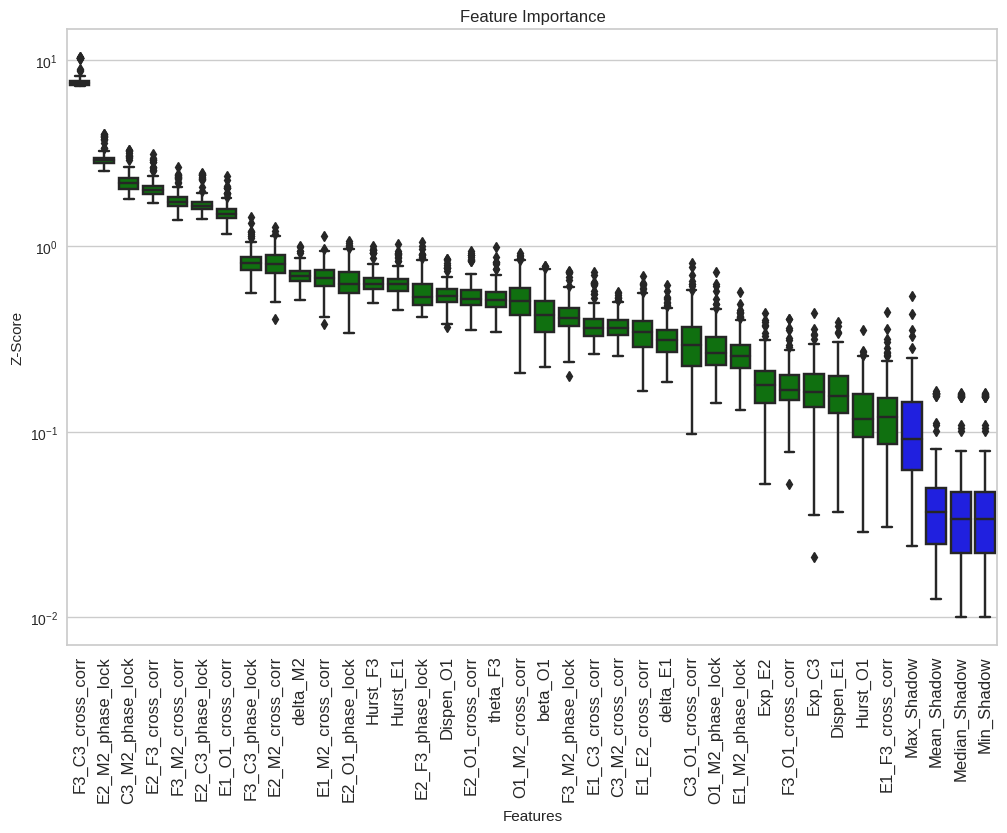

In [21]:
borutashap.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='accepted')

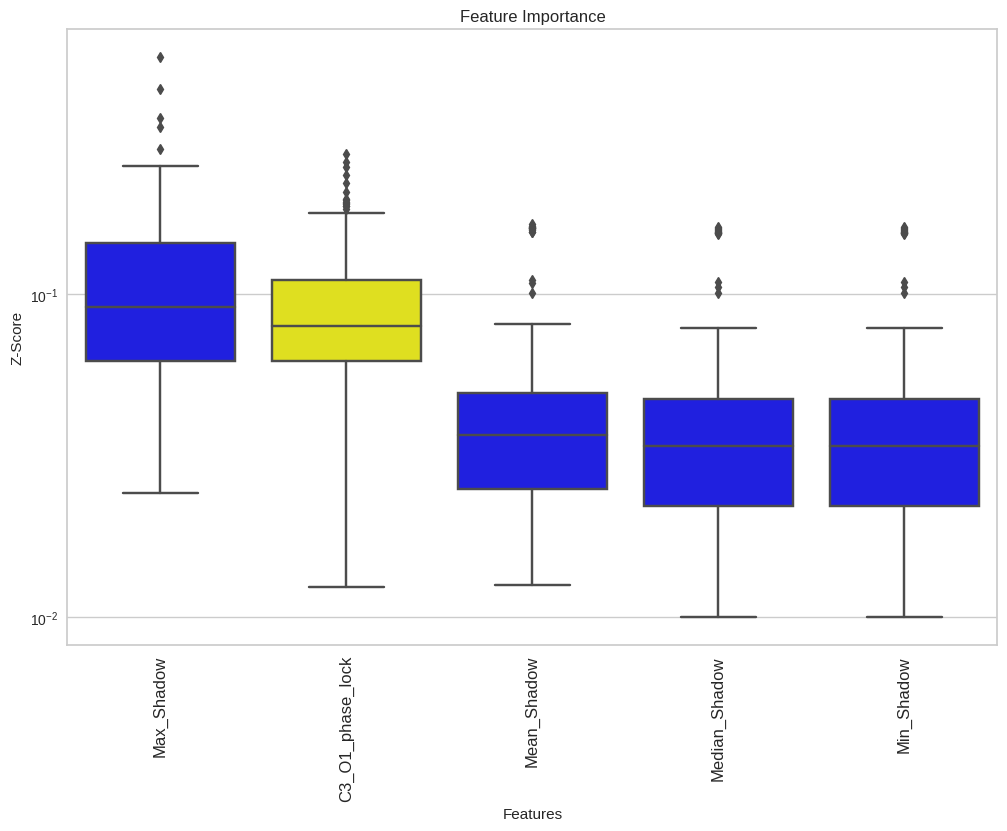

In [22]:
borutashap.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='tentative')

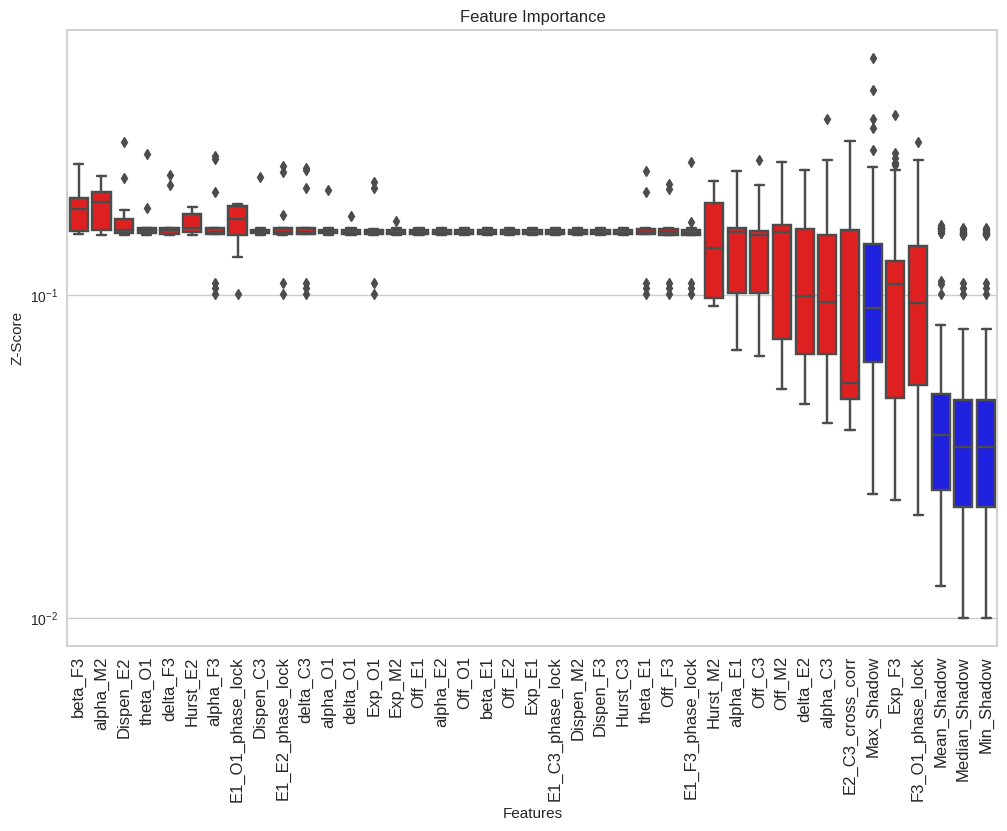

In [23]:
borutashap.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='rejected')

In [12]:
accepted_features = ['Patient_ID', 'Genotype', 'delta_M2', 'E2_C3_phase_lock', 'E2_M2_cross_corr', 'E2_O1_phase_lock',
                     'F3_C3_phase_lock', 'C3_O1_cross_corr', 'Hurst_F3', 'C3_M2_cross_corr',
                     'F3_M2_cross_corr', 'E1_M2_phase_lock', 'E1_E2_cross_corr',
                     'F3_O1_cross_corr', 'Exp_C3', 'E1_C3_cross_corr', 'E2_O1_cross_corr',
                     'E2_F3_cross_corr', 'theta_F3', 'E2_F3_phase_lock', 'C3_M2_phase_lock',
                     'beta_O1', 'E1_O1_cross_corr', 'E2_M2_phase_lock', 'E1_M2_cross_corr', 
                     'E1_F3_cross_corr', 'Hurst_E1', 'delta_E1', 'Dispen_O1', 'Dispen_E1',
                     'F3_C3_cross_corr', 'O1_M2_cross_corr', 'F3_M2_phase_lock', 'Hurst_O1',
                     'O1_M2_phase_lock', 'Exp_E2']

In [13]:
X_train_acc = X_train[accepted_features]
X_test_acc = X_test[accepted_features]

In [14]:
y_train = X_train_acc.iloc[:, 1]
y_test = X_test_acc.iloc[:, 1]

oversample = RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = oversample.fit_resample(X_train_acc, y_train)
X_test_res, y_test_res = oversample.fit_resample(X_test_acc, y_test)
X_train_new = X_train_res.iloc[:, 2:]
X_test_new = X_test_res.iloc[:, 2:]

In [15]:
group_by_patient_id = X_train_res.groupby(['Patient_ID'])
groups_by_patient_id_list = np.array(X_train_res['Patient_ID'].values)
groups_by_patient_id_list

array(['P6', 'P6', 'P6', ..., 'P26', 'P5', 'P16'], dtype=object)

In [16]:
n_splits = 3
group_kfold = GroupKFold(n_splits = n_splits)
print(group_kfold.get_n_splits(X_train_new, y_train_res, groups = groups_by_patient_id_list))

result = []
y_result = []
for train_idx, val_idx in group_kfold.split(X_train_new, y_train_res, groups = groups_by_patient_id_list):
    train_fold = X_train_new.iloc[train_idx]
    val_fold = X_train_new.iloc[val_idx]
    train_y_fold = y_train_res.iloc[train_idx]
    val_y_fold = y_train_res.iloc[val_idx]
    result.append((train_fold, val_fold))
    y_result.append((train_y_fold, val_y_fold))
    
train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]


y_train_fold_1, y_val_fold_1 = y_result[0][0],y_result[0][1]
y_train_fold_2, y_val_fold_2 = y_result[1][0],y_result[1][1]
y_train_fold_3, y_val_fold_3 = y_result[2][0],y_result[2][1]

3


In [17]:
best =  {'colsample_bytree': 0.85, #0.8498520381918202,
         'gamma': 18, 'learning_rate': 0.01, 
         'max_delta_step': 10, 'max_depth': 4, 'min_child_weight': 5,#1.7082081664577191,
         'n_estimators': 2, 'reg_alpha':2, 'reg_lambda': 2, #1.6253557766810953, ,#2.688304103056725,
         'scale_pos_weight': 1.0085730405849205, 'subsample': 0.657} #'subsample': 0.657152595947549}

In [18]:
xgb_grid = xgb.XGBClassifier(**best)
xgb_grid.fit(X_train_new, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=18, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=10,
              max_depth=4, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [19]:
print(xgb_grid.score(train_fold_1, y_train_fold_1))
print(xgb_grid.score(train_fold_2, y_train_fold_2))
print(xgb_grid.score(train_fold_3, y_train_fold_3))
print(xgb_grid.score(X_test_new, y_test_res))

0.9720588235294118
0.9800664451827242
0.9748644652538196
0.8368121442125237


In [20]:
# Save the model to a file
#model_filename = '/home/melissa/RESULTS/FINAL_MODEL/Human/xgb_grid_model.json'

#xgb_grid.save_model(model_filename)
#print(f'Model saved to {model_filename}')

Model saved to /home/melissa/RESULTS/FINAL_MODEL/Human/xgb_grid_model.json


In [ ]:
# Create a new model instance - this should be of the same type as the saved model
xgb_grid = xgb.XGBClassifier()

# Load the model from the file
model_filename = '/home/melissa/RESULTS/FINAL_MODEL/Rat/xgb_grid_model.json'  # or .bst if you used the binary format
xgb_grid.load_model(model_filename)

## Fold 1

In [18]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))
print('F1: ' + str(metrics.f1_score(y_train_fold_1, xgb_grid.predict(train_fold_1))))

Accuracy: 0.9653996101364523
Precision: 0.9621668099742047
Recall: 0.9764397905759162
F1: 0.9692507579038545


## Fold 2

In [19]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))
print('F1: ' + str(metrics.f1_score(y_train_fold_2, xgb_grid.predict(train_fold_2))))

Accuracy: 0.9775656324582339
Precision: 0.9870445344129555
Recall: 0.9752
F1: 0.9810865191146881


## Fold 3

In [20]:
print('Accuracy: ' + str(metrics.accuracy_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('Precision: ' + str(metrics.precision_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('Recall: ' + str(metrics.recall_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))
print('F1: ' + str(metrics.f1_score(y_train_fold_3, xgb_grid.predict(train_fold_3))))

Accuracy: 0.968457368161656
Precision: 0.9266304347826086
Recall: 0.9855491329479769
F1: 0.9551820728291317


## Test set 

In [21]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test_res, xgb_grid.predict(X_test_new))))
print('Precision: ' + str(metrics.precision_score(y_test_res, xgb_grid.predict(X_test_new))))
print('Recall: ' + str(metrics.recall_score(y_test_res, xgb_grid.predict(X_test_new))))
print('F1: ' + str(metrics.f1_score(y_test_res, xgb_grid.predict(X_test_new))))

Accuracy: 0.8444022770398482
Precision: 0.8742268041237113
Recall: 0.8045540796963947
F1: 0.8379446640316205


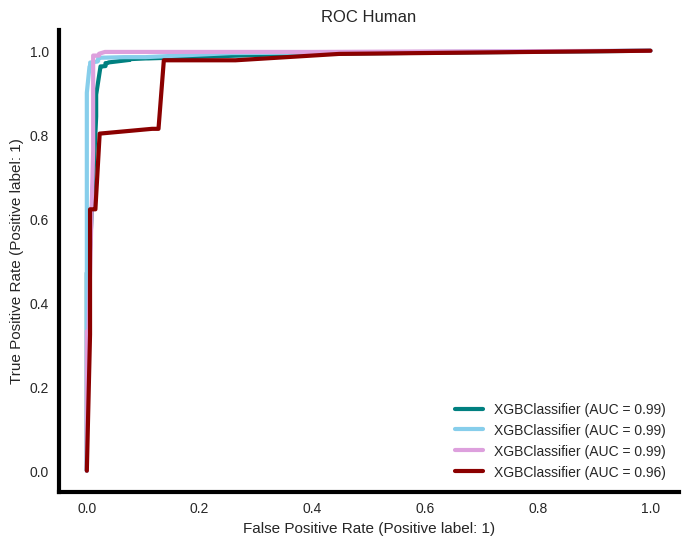

In [18]:
import matplotlib.pyplot as plt
from yellowbrick import classifier
fig, axes = plt.subplots(figsize = (8, 6), ncols = 1)

metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_1, y_train_fold_1, ax = axes, color = 'teal', linewidth=3) #label = 'CV Fold 1', color = 'teal', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_2, y_train_fold_2, ax = axes, color = 'skyblue', linewidth=3) #, label = 'CV Fold 2', color = 'skyblue', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, train_fold_3, y_train_fold_3, ax = axes, color = 'plum', linewidth=3) #, label = 'CV Fold 3', color = 'plum', linewidth=3)
metrics.RocCurveDisplay.from_estimator(xgb_grid, X_test_new, y_test_res, ax = axes, color = 'darkred', linewidth = 3) #, label = 'Test', color='darkred', linewidth=3)
axes.set(title = 'ROC Human')
axes.grid(False)

# Remove the top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# Make bottom (X-axis) and left (Y-axis) spines thicker
axes.spines['bottom'].set_linewidth(3)
axes.spines['left'].set_linewidth(3)
axes.spines['bottom'].set_edgecolor('black')
axes.spines['left'].set_edgecolor('black')

# Remove the background grid
axes.grid(False)
# Save the plot as a PNG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/' + 'dec_new_roc_curve_train_test.jpg', format='png')

# Save the plot as an SVG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/' + 'dec_new_roc_curve_train_test.svg', format='svg')
plt.show()

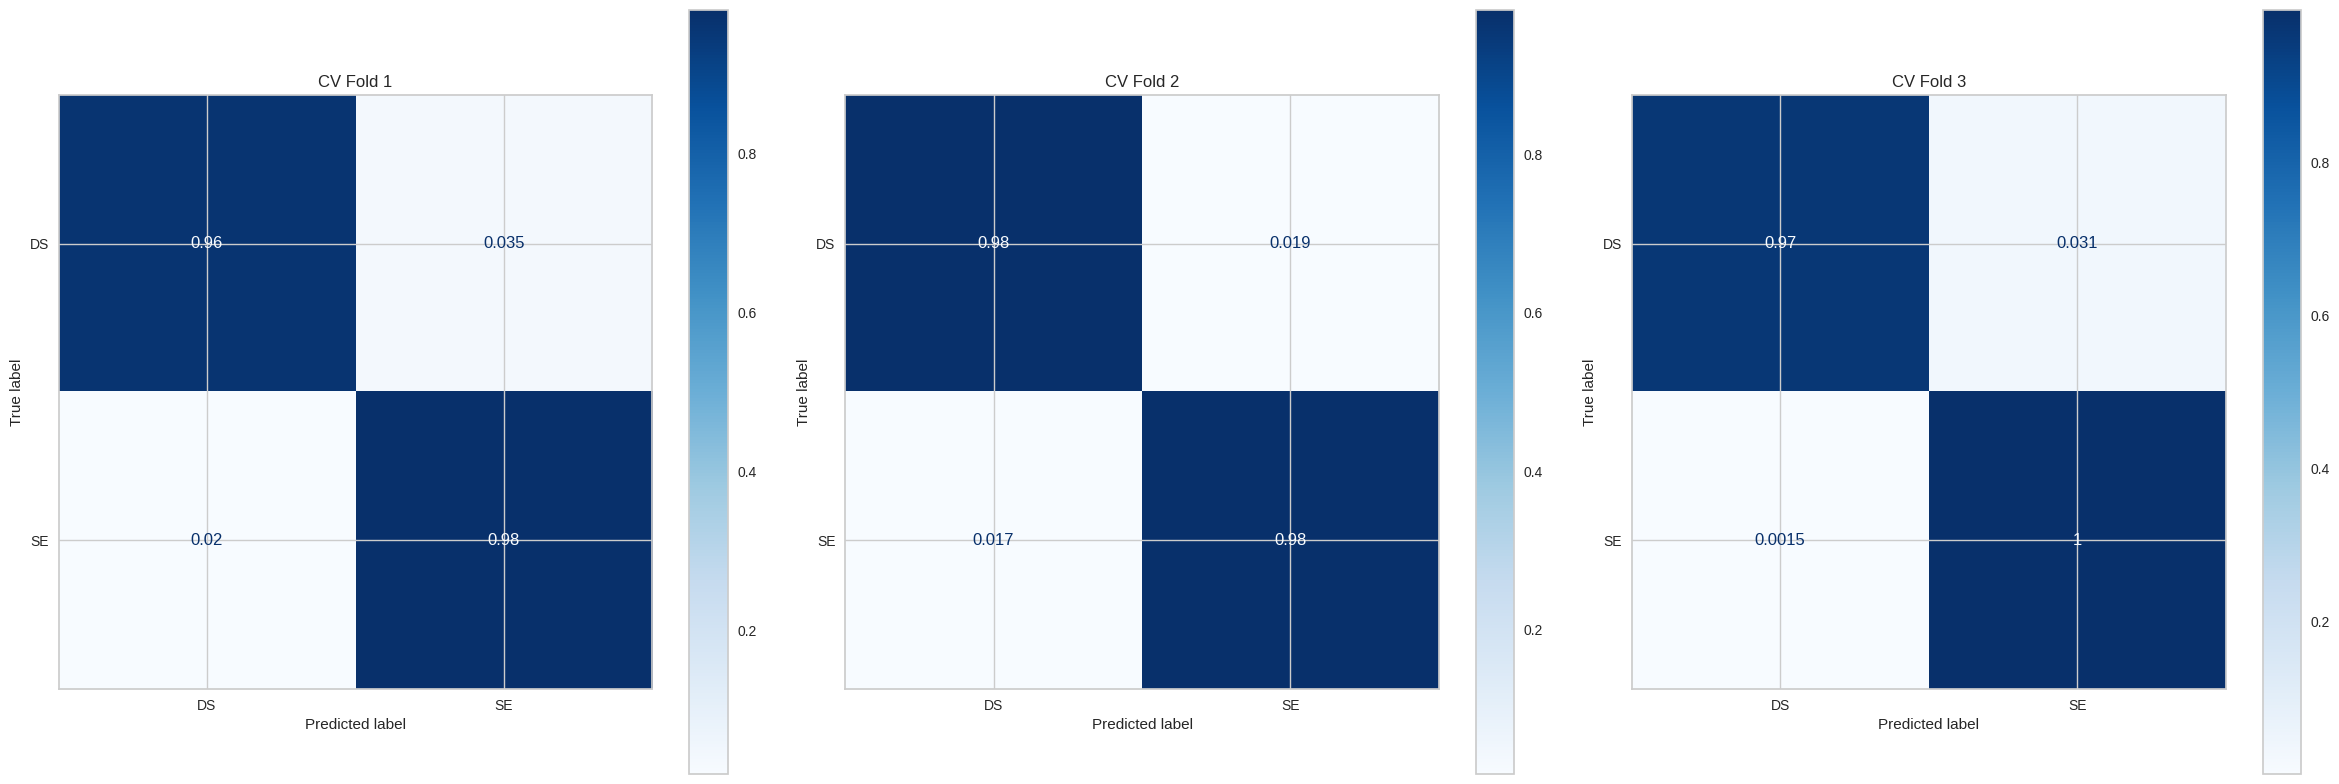

In [41]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

# Confusion Matrix for CV Fold 1
cm1 = metrics.confusion_matrix(y_train_fold_1, xgb_grid.predict(train_fold_1), normalize = 'true')
disp1 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['DS', 'SE'])
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('CV Fold 1')

# Confusion Matrix for CV Fold 2
cm2 = metrics.confusion_matrix(y_train_fold_2, xgb_grid.predict(train_fold_2), normalize = 'true')
disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['DS', 'SE'])
disp2.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('CV Fold 2')

# Confusion Matrix for CV Fold 3
cm3 = metrics.confusion_matrix(y_train_fold_3, xgb_grid.predict(train_fold_3), normalize = 'true')
disp3 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['DS', 'SE'])
disp3.plot(ax=axes[2], cmap='Blues')
axes[2].set_title('CV Fold 3')

# Adjust layout
plt.tight_layout()

# Change directory to save the plots
os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/')

# Save the plots
#plt.savefig('dec_confusion_matrix_cv_folds_normalise.jpg')
#plt.savefig('dec_confusion_matrix_cv_folds_normalise.svg')

plt.show()


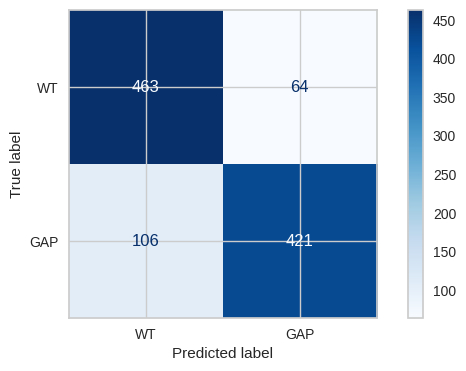

In [42]:
fig, ax = plt.subplots(figsize = (8,4))

cm_test = metrics.confusion_matrix(y_test_res,  xgb_grid.predict(X_test_new)) #, normalize = 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['WT', 'GAP'])
disp.plot(ax = ax, cmap = 'Blues')

os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/')
#plt.savefig('dec_confusion_matrix_test.jpg')
#plt.savefig('dec_confusion_matrix_test.svg')
plt.show()

In [19]:
import shap 
shap.initjs()
shap_ex = shap.TreeExplainer(xgb_grid)
train_vals = shap_ex(X_train_new)
test_vals = shap_ex(X_test_new)

In [20]:
shap_df = pd.DataFrame(train_vals.values, columns = X_train_new.columns)
shap_df

,delta_M2,E2_C3_phase_lock,E2_M2_cross_corr,E2_O1_phase_lock,F3_C3_phase_lock,C3_O1_cross_corr,Hurst_F3,C3_M2_cross_corr,F3_M2_cross_corr,E1_M2_phase_lock,...,Hurst_E1,delta_E1,Dispen_O1,Dispen_E1,F3_C3_cross_corr,O1_M2_cross_corr,F3_M2_phase_lock,Hurst_O1,O1_M2_phase_lock,Exp_E2
0,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.010586,0.0,...,0.0,0.0,0.0,0.0,0.017767,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.010586,0.0,...,0.0,0.0,0.0,0.0,0.020224,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.010586,0.0,...,0.0,0.0,0.0,0.0,0.020224,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.010586,0.0,...,0.0,0.0,0.0,0.0,0.017767,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.010586,0.0,...,0.0,0.0,0.0,0.0,0.017767,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,0.0,0.0,0.0,0.0,0.032253,0.0,0.0,0.0,-0.000895,0.0,...,0.0,0.0,0.0,0.0,-0.019380,0.0,0.0,0.0,0.0,0.0
3084,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.003076,0.0,...,0.0,0.0,0.0,0.0,0.021071,0.0,0.0,0.0,0.0,0.0
3085,0.0,0.0,0.0,0.0,-0.001264,0.0,0.0,0.0,0.001574,0.0,...,0.0,0.0,0.0,0.0,0.026520,0.0,0.0,0.0,0.0,0.0
3086,0.0,0.0,0.0,0.0,0.005150,0.0,0.0,0.0,0.003076,0.0,...,0.0,0.0,0.0,0.0,0.021071,0.0,0.0,0.0,0.0,0.0


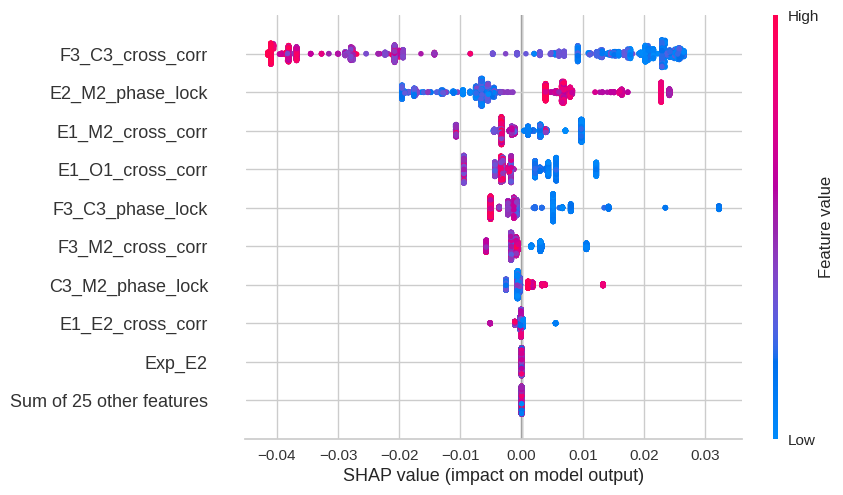

In [25]:
fig = plt.figure(figsize = (8, 4))
shap.plots.beeswarm(train_vals, max_display = len(X_train_new.columns[0:10]))


# Save the figure as a PNG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/shap_beeswarm_plot_train.png', format='png')

# Save the figure as an SVG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/shap_beeswarm_plot_train.svg', format='svg')

#plt.show()  # Display the plot

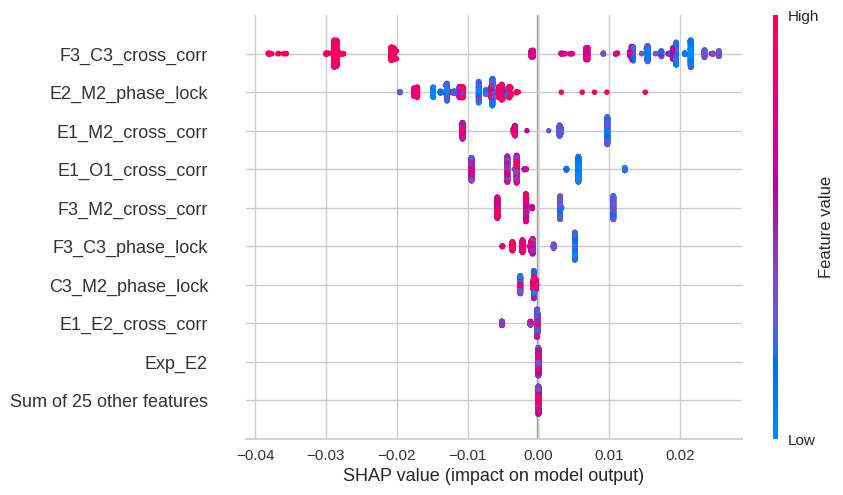

In [22]:
fig = plt.figure(figsize = (8, 4))
shap.plots.beeswarm(test_vals, max_display = len(X_test_new.columns[0:10]))

# Attempt to access the current axes and remove the grid

# Save the figure as a PNG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/shap_beeswarm_plot_test_shortened.png', format='png')

# Save the figure as an SVG file
#plt.savefig('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/shap_beeswarm_plot_test_shortened.svg', format='svg')

plt.show()  # Display the plot

## Undestanding features with dependence plots 

<Figure size 800x400 with 0 Axes>

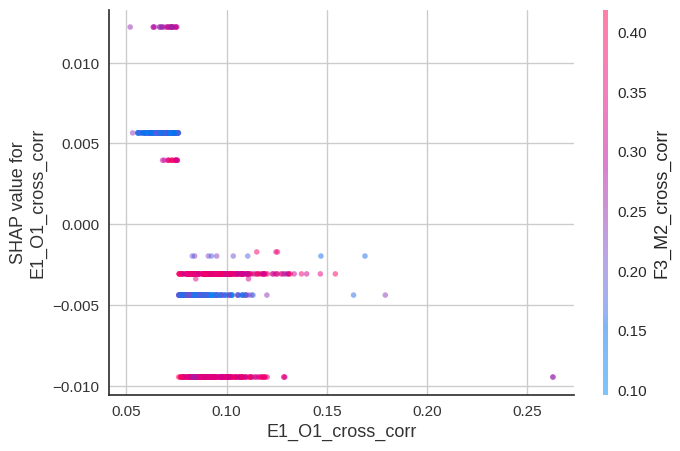

In [33]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(test_vals[:, 'E1_O1_cross_corr'], color = test_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/Dependence_Plots/')
#plt.savefig('F3_C3_cc.png', format='png')
#plt.savefig('F3_C3_cc.svg', format='svg')

<Figure size 800x400 with 0 Axes>

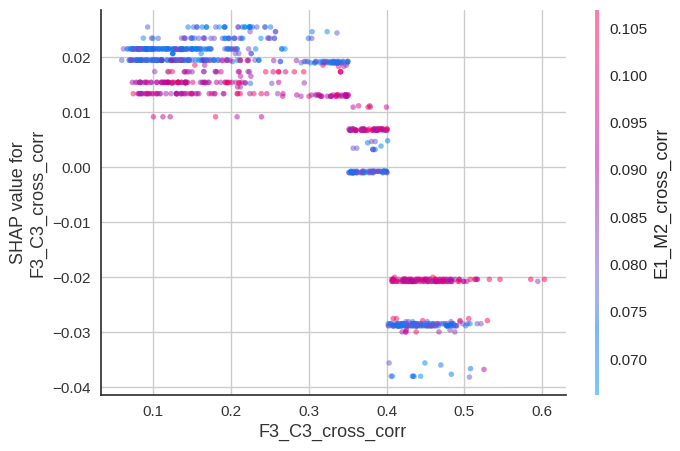

In [24]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(test_vals[:, 'F3_C3_cross_corr'], color = test_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/Dependence_Plots/')
#plt.savefig('F3_C3_cc.png', format='png')
#plt.savefig('F3_C3_cc.svg', format='svg')

<Figure size 800x400 with 0 Axes>

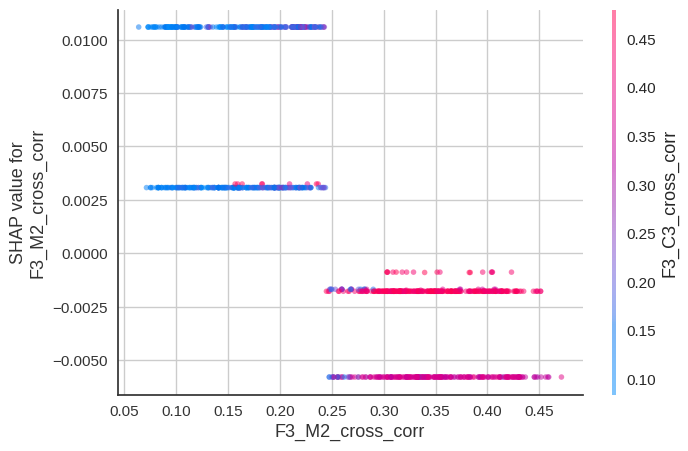

In [26]:
fig = plt.figure(figsize = (8, 4))
shap.plots.scatter(test_vals[:, 'F3_M2_cross_corr'], color = test_vals,x_jitter = 1,alpha = 0.5, hist = False)
#os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/Dependence_Plots/')
#plt.savefig('F3_C3_cc.png', format='png')
#plt.savefig('F3_C3_cc.svg', format='svg')

## Percentage of correct predictions per animal 

In [62]:
pred_train = xgb_grid.predict(X_train_new)
copy_X_train_res = X_train_res.copy()
copy_X_train_res["pred"] = pred_train

In [63]:
count_matches = copy_X_train_res['Genotype'].eq(copy_X_train_res['pred']).groupby(copy_X_train_res['Patient_ID']).sum()

print(count_matches / copy_X_train_res.groupby("Patient_ID").count()["Genotype"])

Patient_ID
P10    1.000000
P16    1.000000
P17    1.000000
P20    0.921348
P21    0.979624
P24    0.985507
P26    0.996324
P27    0.965000
P28    0.949192
P5     0.977591
P6     1.000000
dtype: float64


In [77]:
pred_test = xgb_grid.predict(X_test_res.iloc[:, 2:])
copy_X_test_res = X_test_res.copy()
copy_X_test_res["pred"] = pred_test

In [79]:
copy_X_test_new= X_test_res.copy()
copy_X_test_new["pred"] = pred_test

count_matches = copy_X_test_res['Genotype'].eq(copy_X_test_res['pred']).groupby(copy_X_test_res['Patient_ID']).sum()

print(count_matches / copy_X_test_res.groupby("Patient_ID").count()["Genotype"])

Patient_ID
P1    0.878558
P7    0.798861
dtype: float64


## SHAP and pearson heatmap plots

In [26]:
import shap 
import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()
shap_ex = shap.TreeExplainer(xgb_grid)
train_vals = shap_ex(X_train_new)
test_vals = shap_ex(X_test_new)

In [28]:
shap_df = pd.DataFrame(test_vals.values, columns = X_test_new.columns)
shap_df

,delta_M2,E2_C3_phase_lock,E2_M2_cross_corr,E2_O1_phase_lock,F3_C3_phase_lock,C3_O1_cross_corr,Hurst_F3,C3_M2_cross_corr,F3_M2_cross_corr,E1_M2_phase_lock,...,Hurst_E1,delta_E1,Dispen_O1,Dispen_E1,F3_C3_cross_corr,O1_M2_cross_corr,F3_M2_phase_lock,Hurst_O1,O1_M2_phase_lock,Exp_E2
0,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,0.007039,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,-0.000477,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,-0.000477,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,0.007039,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,0.007039,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,0.0,0.0,0.0,0.0,0.004989,0.0,0.0,0.0,0.003527,0.0,...,0.0,0.0,0.0,0.0,0.021871,0.0,0.0,0.0,0.0,0.0
1050,0.0,0.0,0.0,0.0,-0.000792,0.0,0.0,0.0,-0.004786,0.0,...,0.0,0.0,0.0,0.0,0.019392,0.0,0.0,0.0,0.0,0.0
1051,0.0,0.0,0.0,0.0,0.004989,0.0,0.0,0.0,0.003527,0.0,...,0.0,0.0,0.0,0.0,0.015715,0.0,0.0,0.0,0.0,0.0
1052,0.0,0.0,0.0,0.0,0.004989,0.0,0.0,0.0,0.012402,0.0,...,0.0,0.0,0.0,0.0,0.020089,0.0,0.0,0.0,0.0,0.0


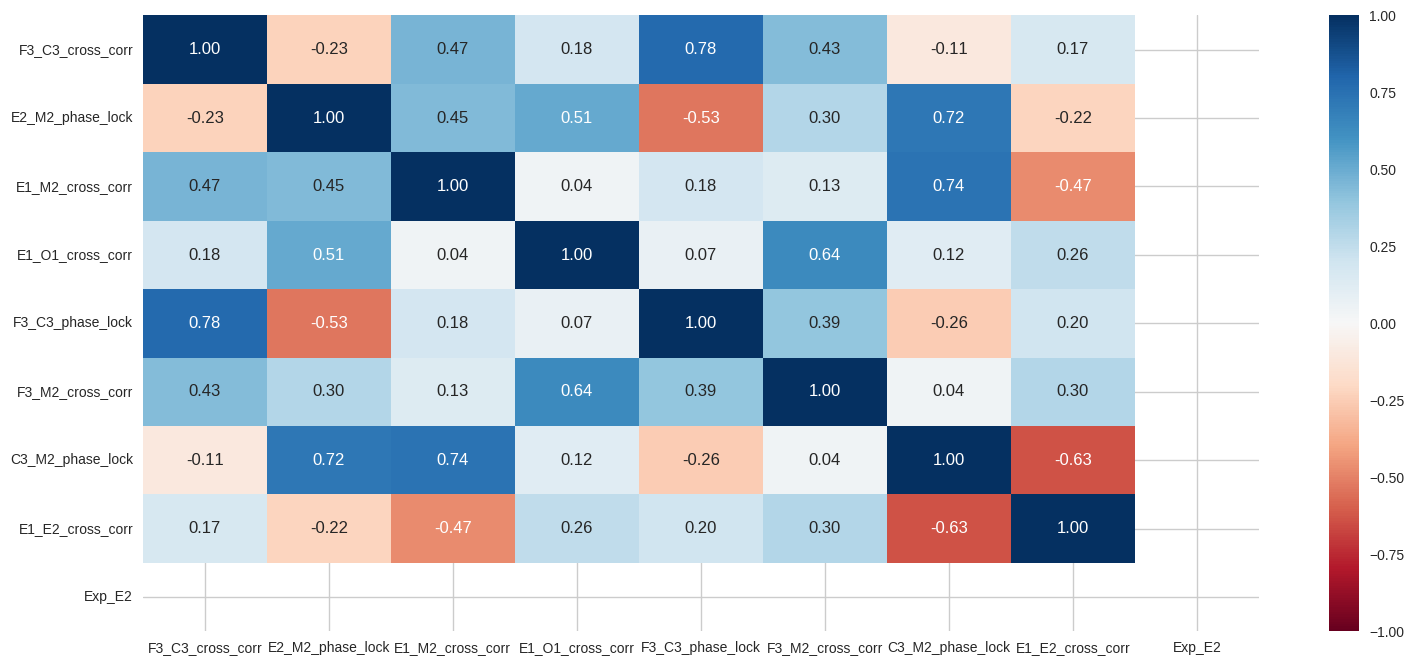

In [38]:
# Define the list of features
features = ['F3_C3_cross_corr', 'E2_M2_phase_lock', 'E1_M2_cross_corr', 'E1_O1_cross_corr',
           'F3_C3_phase_lock', 'F3_M2_cross_corr', 'C3_M2_phase_lock', 'E1_E2_cross_corr',
           'Exp_E2']

# Assuming 'shap_df' is your DataFrame and it contains these features
# Compute the Spearman correlation matrix using these features
corr_matrix = shap_df[features].corr(method='spearman')

# Create the heatmap
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax)

os.chdir('/home/melissa/RESULTS/FINAL_MODEL/Human/Model_Evaluation_Plots/XGBoost/')
plt.savefig('shap_heatmap_spearman_corr.png', format='png')
plt.savefig('shap_heatmap_spearman_corr.svg', format='svg')
